#Методы прогнозирования связей в графах с использованием машинного обучения.

Ветрова Елизавета

Группа: ПМ22-6

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy.stats import linregress
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, GAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import train_test_split_edges
import torch.nn.functional as F
import networkx as nx
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index, resource_allocation_index
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tqdm
import tarfile
from sklearn.metrics import classification_report, precision_recall_curve
from node2vec import Node2Vec
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import degree
import time

In [ ]:
pip install torch_geometric

In [ ]:
pip install node2vec

In [ ]:
!pip install numpy==1.23.5
!pip install torch==1.12.0

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy.stats import linregress
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import networkx as nx
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index, resource_allocation_index
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tqdm
import tarfile
from sklearn.metrics import classification_report, precision_recall_curve
import time

##Описание датасета

Набор данных - **"Social circles: Facebook**" является частью коллекции Stanford Large Network Dataset Collection (SNAP). Это социальный граф, полученный из социальной сети Facebook - пользователи, их признаки(анонимные) и друзья. Также, в этом датасете есть ego-графы - для каждого "эго-узла"  указан список его друзей и то, как они сгруппированы в социальные круги.

Целью данной работы является создание модели для предсказания связей в графе, основываясь на структуре графа и признаках узлов. (Link Prediction).

Поскольку задача предсказания связей является задачей бинарной классификацией (есть ребро или нет), для оценки моделей будут использованы следующие метрики:

**ROC AUC** (Receiver Operating Characteristic Area Under the Curve) - это метрика, используемая в задачах классификации машинного обучения для измерения площади под кривой receiver operating characteristic (ROC). Она оценивает компромисс между частотой истинных и ложных положительных результатов при различных пороговых значениях классификации.

**F1 Score** - это гармоническое среднее между Precision и Recall, которое представляет собой компромисс между ними. F1 Score объединяет Precision и Recall в одну метрику и обычно используется в задачах классификации для оценки сбалансированности модели.

##Предварительный анализ данных

In [ ]:
edges = pd.read_csv('facebook_combined.txt', sep=' ', header=None)
edges.columns = ['node1', 'node2']
edges.head()

,node1,node2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [ ]:
print("Информация о данных:")
edges.info()

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88234 entries, 0 to 88233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   node1   88234 non-null  int64
 1   node2   88234 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB


In [ ]:
print("Пропущенные значения:")
edges.isnull().sum()

Пропущенные значения:


,0
node1,0
node2,0


In [ ]:
G = nx.from_pandas_edgelist(edges, source='node1', target='node2')
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / num_nodes

In [ ]:
print(f'Количество узлов: {num_nodes}')
print(f'Количество связей: {num_edges}')
print(f'Плотность графа: {density:.2f}')
print(f'Средняя степень узла: {avg_degree:.2f}')

Количество узлов: 4039
Количество связей: 88234
Плотность графа: 0.01
Средняя степень узла: 43.69


In [ ]:
nx.is_directed(G) #Граф ненаправленный

False

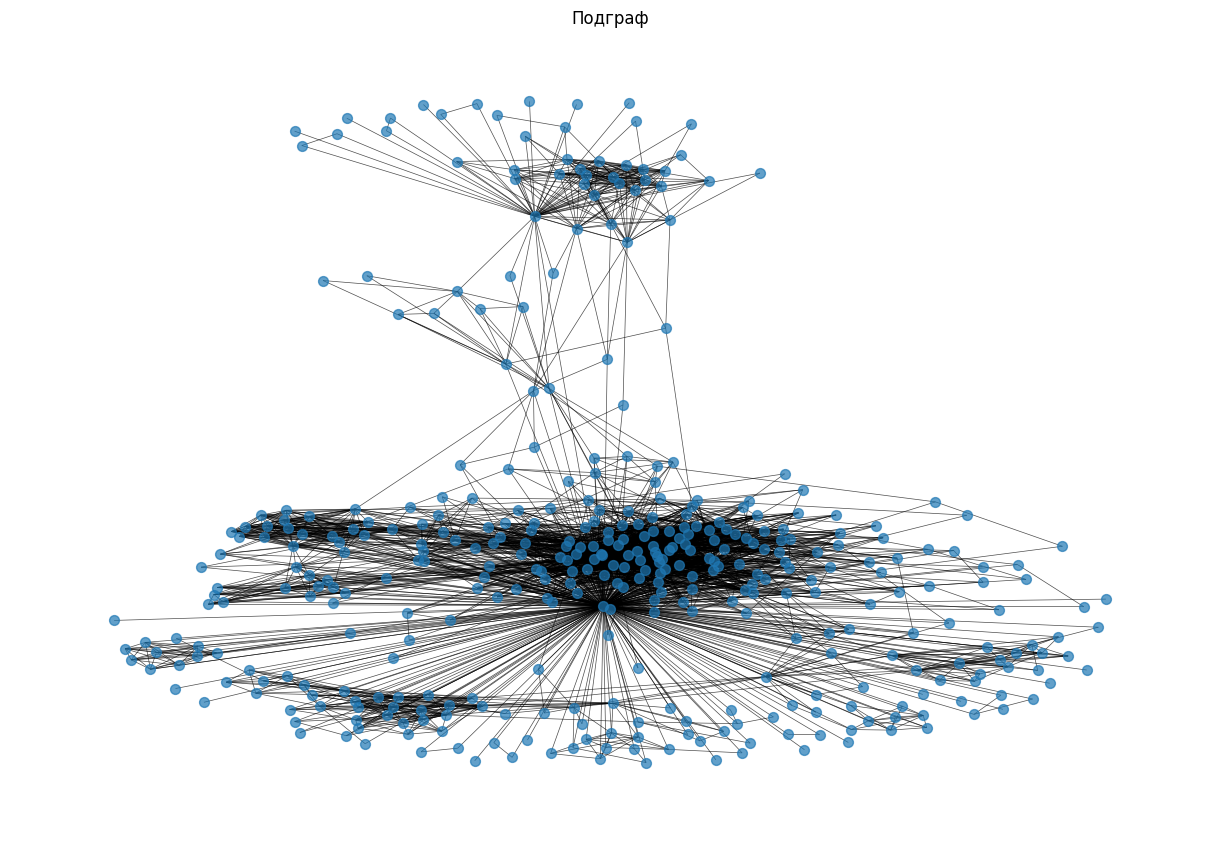

In [ ]:
subgraph = G.subgraph(list(G.nodes())[:400])

plt.figure(figsize=(12, 8))
nx.draw(
    subgraph,
    node_size=50,
    width=0.5,
    alpha=0.7,
    with_labels=False
)
plt.title("Подграф")
plt.show()

Граф неориентированный, количество узлов в графе - 4039, количество связей - 88234, плотность графа - 0.01 (существует всего 1% от всех возможных связей), стредняя степень узла 43.69 (в среднем у пользователей по 43 друга).

## Закон Ципфа

$x_r \propto \frac{1}{r^\alpha}$

В упорядоченном по убыванию списке элементов значение $x_r$ обратно пропорционально рангу.

Закон Ципфа используется для того, чтобы проверить насколько связи в графе являются реальными. Если распределение степеней узлов подчиняется закону ципфа, то на графике мы увидим зависимость близкую к линейной.

Коэффициент детерминации R^2: 0.7355


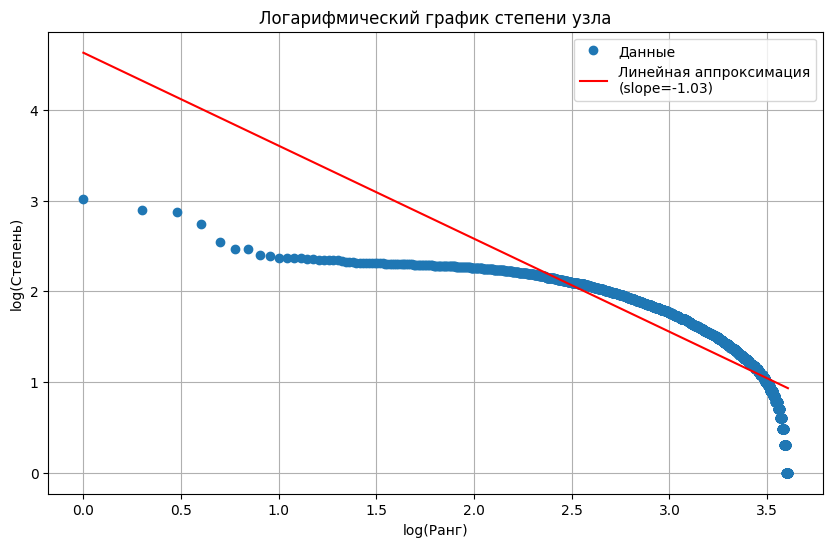

In [ ]:
degrees = [degree for node, degree in G.degree() if degree > 0]
degrees_sorted = sorted(degrees, reverse=True)

ranks = np.arange(1, len(degrees_sorted) + 1)
log_ranks = np.log10(ranks)
log_degrees = np.log10(degrees_sorted)

slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_degrees)

print(f"Коэффициент детерминации R^2: {r_value**2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(log_ranks, log_degrees, marker='o', linestyle='none', label='Данные')
plt.plot(log_ranks, slope * log_ranks + intercept, color='red', label=f'Линейная аппроксимация\n(slope={slope:.2f})')
plt.xlabel('log(Ранг)')
plt.ylabel('log(Степень)')
plt.title('Логарифмический график степени узла')
plt.legend()
plt.grid(True)
plt.show()

Вывод:

На графике наблюдается выпуклость вверх. Это объясняется наличием центральных пользователей с большим количеством связей. Можно сказать, что данные близки к реальным, так как во всех социальных сетях есть популярные пользователи с большим количество подписчиков.

## Классические методы прогнозирования связей в графе:

Делим данные на обучающую (80%) и тестовую(20%) выборки. Удаляем тестовые ребра из графа, чтобы имитировать предсказание новых связей, оценим насколько хорошо классические методы справляются с этой задачей.

Коэффициент Жаккара (Jaccard’s coefficient) - $\frac{|Γ(x)∩Γ(y)|} {|Γ(x)∪Γ(y)|}$ - отношение числа общих друзей к сумме всех друзей.

In [ ]:
edges_lst = list(G.edges())
train_edges, test_edges = train_test_split(edges_lst, test_size=0.2, random_state=42)

G_train = nx.Graph()
G_train.add_edges_from(train_edges)

test_edges = [(u, v) for u, v in test_edges if u in G_train and v in G_train]
non_edges_sample = random.sample(list(nx.non_edges(G_train)), len(test_edges))

eval_edges = test_edges + non_edges_sample
labels = [1] * len(test_edges) + [0] * len(non_edges_sample)

In [ ]:
jaccard_scores = list(nx.jaccard_coefficient(G_train, eval_edges))
scores = [score for _, _, score in jaccard_scores]

auc = roc_auc_score(labels, scores)
print(f"Jaccard Coefficient AUC: {auc:.2f}")

Jaccard Coefficient AUC: 0.99


Адамик/Адар (Adamic/Adar) - $
\sum_{z \in \Gamma(x) \cap \Gamma(y)} \frac{1}{\log |\Gamma(z)|}$ - взвешенная сумма общих друзей двух кандидатов.

Данный метод учитывает не только факт наличия общих друзей, но и их популярность.
Например, если у двух пользователей есть общий друг с малым числом подписчиков(10 пользователей), то это сильнее указывает на связь, чем если общий друг - известная личность с числом подписчиков 500 тысяч.

In [ ]:
adamic_scores = list(nx.adamic_adar_index(G_train, eval_edges))
scores = [score for _, _, score in adamic_scores]

auc = roc_auc_score(labels, scores)
print(f"Adamic/Adar AUC: {auc:.2f}")

Adamic/Adar AUC: 0.99


In [ ]:
leakage_edges = []
for u, v in test_edges:
    common_neighbors = set(G_train.neighbors(u)) & set(G_train.neighbors(v))
    if common_neighbors:
        leakage_edges.append((u, v))

print(f"Тестовых рёбер с общими соседями в train: {len(leakage_edges)}/{len(test_edges)}")

Тестовых рёбер с общими соседями в train: 17535/17620


Общие соседи - сильный индикатор будущих связей. Почти у всех тестовых пар есть эти соседи в тестовой выборке. Но у 85 ребер нет общих соседей в трейне. Проверим, как классические методы поведут себя в этой ситуации.

In [ ]:
hard_test_edges = [
    (u, v) for u, v in test_edges
    if len(set(G_train.neighbors(u)) & set(G_train.neighbors(v))) == 0
]
print(f"Число сложных рёбер: {len(hard_test_edges)}")

Число сложных рёбер: 85


In [ ]:
non_edges = list(nx.non_edges(G_train))
random_non_edges = [
    (u, v) for u, v in non_edges
    if len(set(nx.common_neighbors(G_train, u, v))) == 0
]

random_non_edges = random.sample(random_non_edges, len(hard_test_edges))

In [ ]:
y_true = [1] * len(hard_test_edges) + [0] * len(random_non_edges)

jaccard_scores = nx.jaccard_coefficient(G_train, hard_test_edges + random_non_edges)
y_scores_jaccard = [score for _, _, score in jaccard_scores]

adamic_scores = nx.adamic_adar_index(G_train, hard_test_edges + random_non_edges)
y_scores_adamic = [score for _, _, score in adamic_scores]

print(f"Jaccard AUC: {roc_auc_score(y_true, y_scores_jaccard):.3f}")
print(f"Adamic-Adar AUC: {roc_auc_score(y_true, y_scores_adamic):.3f}")

Jaccard AUC: 0.500
Adamic-Adar AUC: 0.500


AUC = 0.5 говорит о том, что методы работают как случайное угадывание, что логично, так как они полагаются исключительно на общих соседей, которых нет у отобранных пар.

Классические методы предсказания связей (Жаккар, Адамик/Адар) не способны выявлять скрытые закономерности, когда связи не объясняются общими соседями. Как показал эксперимент, на таких примерах алгоритмы работают на уровне случайного угадывания.

Попробуем преодолеть это ограничение, с помощью современных методов прогнозирования связей в графах.

##Современные методы прогнозирования связей в графах

### Извлечение и обработка признаков

Распаковываем архив, который содержит данные эго-графов. Каждый граф включает в себя файл (.feat) с бинарными признаками пользователей и файл (.featnames) с названиями признаков.

In [ ]:
with tarfile.open('facebook.tar.gz', 'r:gz') as tar:
    tar.extractall()

Объединяем все .feat-файлы в одну таблицу признаков. Для каждого файла сохраняется ID-центрального пользователя, которому принадлежит граф.

In [ ]:
all_feat = []
for fname in os.listdir("/content/facebook"):
    if fname.endswith(".feat"):
        path = os.path.join("/content/facebook", fname)
        ego_id = int(fname.split('.')[0])
        df = pd.read_csv(path, sep=' ', header=None)
        df['ego_id'] = ego_id
        all_feat.append(df)

features_df = pd.concat(all_feat, ignore_index=True)
features_df = features_df.drop_duplicates(subset=[0], keep='first')
feature_matrix = csr_matrix(features_df.iloc[:, 1:-1].values)
user_ids = features_df[0].values

print(f"Всего пользователей: {len(user_ids)}")
print(f"Размерность матрицы признаков: {feature_matrix.shape}")

Всего пользователей: 4035
Размерность матрицы признаков: (4035, 576)


Добавляем названия признаков для наглядности.

In [ ]:
feat_names = []
for fname in os.listdir("/content/facebook"):
    if fname.endswith(".featnames"):
        path = os.path.join("/content/facebook", fname)
        with open(path, 'r') as f:
            names = [line.strip().split(' ', 1)[1] for line in f.readlines()]
            feat_names.extend(names)
unique_feat_names = list(set(feat_names))
print(f"Уникальных признаков: {len(unique_feat_names)}")

Уникальных признаков: 1406


In [ ]:
features_df.columns = ['user_id'] + feat_names[:features_df.shape[1]-2] + ['ego_id']

Так как разные графы имеют разный набор признаков, оставляем только общие. Анализ показал, что для трех пользователей признаки отсутствуют, эти значения были заполнены нулями.

In [ ]:
features_df = features_df.dropna(axis=1)
features_df = features_df.sort_values(by='user_id')
features_df = features_df.reset_index(drop=True)

In [ ]:
features_df['user_id'] = features_df['user_id'].astype(int)
full_ids = pd.DataFrame({'user_id': np.arange(4039)})
full_features = full_ids.merge(features_df, on='user_id', how='left')
full_features = full_features.fillna(0)
full_features = full_features.drop(columns=['user_id'])
full_features

,birthday;anonymized feature 0,birthday;anonymized feature 1,birthday;anonymized feature 2,birthday;anonymized feature 3,birthday;anonymized feature 4,birthday;anonymized feature 5,birthday;anonymized feature 6,birthday;anonymized feature 7,education;classes;id;anonymized feature 8,education;classes;id;anonymized feature 9,...,education;school;id;anonymized feature 33,education;school;id;anonymized feature 34,education;school;id;anonymized feature 35,education;school;id;anonymized feature 36,education;school;id;anonymized feature 37,education;school;id;anonymized feature 38,education;school;id;anonymized feature 39,education;school;id;anonymized feature 40,education;school;id;anonymized feature 41,education;school;id;anonymized feature 48
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3980.0
4035,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3980.0
4036,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3980.0
4037,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3980.0


### Подготовка графа

На данном этапе граф преобразуется в формат edge_index совместимый с PyTorch Geometric, а признаки узлов в тензор x. С помощью RandomLinkSplit данные делятся на обучающую (80%) и тестовую (20%) выборки. Автоматически формируются отрицательные примеры (пары без связи), необходимые для обучения.

In [ ]:
nodes = list(G.nodes())
node_mapping = {node: i for i, node in enumerate(nodes)}
mapped_edges = [(node_mapping[u], node_mapping[v]) for u, v in G.edges()]
edge_index = torch.tensor(mapped_edges, dtype=torch.long).t().contiguous()

x = torch.tensor(full_features.values.astype(np.float32), dtype=torch.float32) #векторы признаков

data = Data(x=x, edge_index=edge_index)

transform = RandomLinkSplit(
    is_undirected=True,
    split_labels=False,
    add_negative_train_samples=True,
    num_val=0.0,
    num_test=0.2
)

train_data, _, test_data = transform(data)

In [ ]:
print(data)
print(train_data)
print(test_data)

Data(x=[4039, 43], edge_index=[2, 88234])
Data(x=[4039, 43], edge_index=[2, 141176], edge_label=[141176], edge_label_index=[2, 141176])
Data(x=[4039, 43], edge_index=[2, 141176], edge_label=[35292], edge_label_index=[2, 35292])


### Модель глубокого обучения

Модель состоит из трёх последовательных SAGEConv с BatchNorm и Dropout, после чего выходы третьего слоя нормализуются по L₂-норме и служат эмбеддингами узлов.

**SAGEConv** - это вариант архитектуры GraphSAGE, которая является популярной архитектурой GNN. Она изучает представления узлов путем агрегирования информации из окрестностей каждого узла. Использует нормализированное усреднение признаков соседей с учетом их степени, что позволяет точнее учитывать структуру графа.


In [ ]:
class Model(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1   = nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2   = nn.BatchNorm1d(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)


        feat_dim = out_channels * 3
        self.fc1    = nn.Linear(feat_dim, hidden_channels)
        self.bn3    = nn.BatchNorm1d(hidden_channels)
        self.fc2    = nn.Linear(hidden_channels, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_pairs=None):
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = F.normalize(x, p=2, dim=-1)

        if edge_pairs is not None:
            u, v = edge_pairs
            x_u, x_v = x[u], x[v]

            prod = x_u * x_v
            edge_feat = torch.cat([x_u, x_v, prod], dim=-1)

            h = F.relu(self.bn3(self.fc1(edge_feat)))
            h = self.dropout(h)
            return torch.sigmoid(self.fc2(h)).squeeze()
        return x

### Обучение

In [ ]:
model = Model(in_channels=43, hidden_channels=256, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
criterion = nn.BCELoss()

In [ ]:
def train(model, criterion, optimizer, train_data, test_data, epochs):
    train_losses = []
    train_roc_aucs = []
    train_f1s = []
    test_roc_aucs = []
    test_f1s = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(train_data.x, train_data.edge_index, edge_pairs=train_data.edge_label_index)
        loss = criterion(out.view(-1), train_data.edge_label.float())
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                train_out = model(train_data.x, train_data.edge_index, edge_pairs=train_data.edge_label_index)
                train_scores = train_out.cpu().numpy()
                train_preds = (train_scores > 0.5).astype(int)
                train_labels_np = train_data.edge_label.cpu().numpy()
                train_roc_auc = roc_auc_score(train_labels_np, train_scores)
                train_f1 = f1_score(train_labels_np, train_preds)

                test_out = model(test_data.x, test_data.edge_index, edge_pairs=test_data.edge_label_index)
                test_scores = test_out.cpu().numpy()
                test_preds = (test_scores > 0.5).astype(int)
                test_labels_np = test_data.edge_label.cpu().numpy()
                test_roc_auc = roc_auc_score(test_labels_np, test_scores)
                test_f1 = f1_score(test_labels_np, test_preds)

                train_losses.append(loss.item())
                train_roc_aucs.append(train_roc_auc)
                train_f1s.append(train_f1)
                test_roc_aucs.append(test_roc_auc)
                test_f1s.append(test_f1)

                print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | "
                      f"Train ROC-AUC: {train_roc_auc:.4f}, F1: {train_f1:.4f} | "
                      f"Test ROC-AUC: {test_roc_auc:.4f}, F1: {test_f1:.4f}")
    return train_losses, train_roc_aucs, train_f1s, test_roc_aucs, test_f1s

In [ ]:
def graphics(train_losses, train_roc_aucs, test_roc_aucs, train_f1s, test_f1s):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(0, len(train_losses) * 10, 10), train_losses, label='Train Loss', color='#228B22')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(range(0, len(train_roc_aucs) * 10, 10), train_roc_aucs, label='Train ROC-AUC', color='LightCoral')
    plt.plot(range(0, len(test_roc_aucs) * 10, 10), test_roc_aucs, label='Test ROC-AUC', color='#228B22')
    plt.title('ROC-AUC Score')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(range(0, len(train_f1s) * 10, 10), train_f1s, label='Train F1', color='LightCoral')
    plt.plot(range(0, len(test_f1s) * 10, 10), test_f1s, label='Test F1', color='#228B22')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [ ]:
start_time = time.time()

train_losses, train_roc_aucs, train_f1s, test_roc_aucs, test_f1s = train(model, criterion, optimizer, train_data, test_data, epochs=100)

end_time = time.time()

Epoch 000 | Loss: 0.7171 | Train ROC-AUC: 0.6257, F1: 0.0520 | Test ROC-AUC: 0.6256, F1: 0.0532
Epoch 010 | Loss: 0.3424 | Train ROC-AUC: 0.8328, F1: 0.8063 | Test ROC-AUC: 0.8305, F1: 0.8026
Epoch 020 | Loss: 0.2640 | Train ROC-AUC: 0.8941, F1: 0.8456 | Test ROC-AUC: 0.8913, F1: 0.8462
Epoch 030 | Loss: 0.2229 | Train ROC-AUC: 0.9531, F1: 0.9046 | Test ROC-AUC: 0.9511, F1: 0.9037
Epoch 040 | Loss: 0.1984 | Train ROC-AUC: 0.9709, F1: 0.9125 | Test ROC-AUC: 0.9708, F1: 0.9113
Epoch 050 | Loss: 0.1802 | Train ROC-AUC: 0.9728, F1: 0.9234 | Test ROC-AUC: 0.9728, F1: 0.9232
Epoch 060 | Loss: 0.1701 | Train ROC-AUC: 0.9781, F1: 0.9232 | Test ROC-AUC: 0.9775, F1: 0.9228
Epoch 070 | Loss: 0.1631 | Train ROC-AUC: 0.9768, F1: 0.9268 | Test ROC-AUC: 0.9764, F1: 0.9246
Epoch 080 | Loss: 0.1564 | Train ROC-AUC: 0.9786, F1: 0.9396 | Test ROC-AUC: 0.9780, F1: 0.9386
Epoch 090 | Loss: 0.1493 | Train ROC-AUC: 0.9807, F1: 0.9458 | Test ROC-AUC: 0.9793, F1: 0.9436


In [ ]:
print(f"Время обучения: {(end_time - start_time)/60:.2f} минут")

Время обучения: 4.54 минут


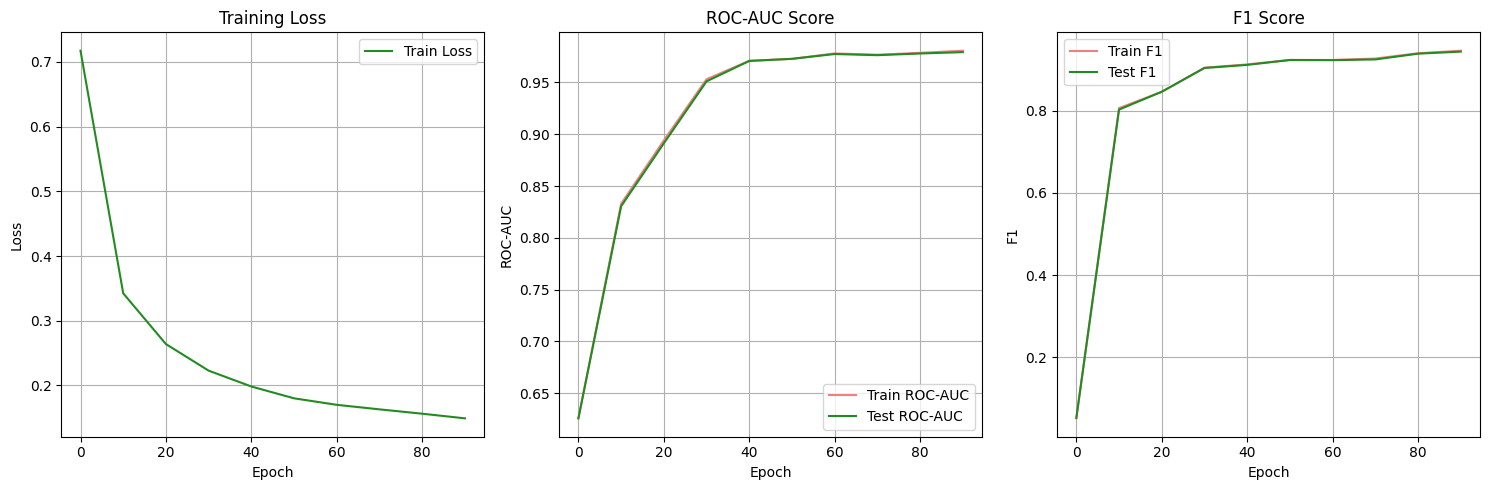

In [ ]:
graphics(train_losses, train_roc_aucs, test_roc_aucs, train_f1s, test_f1s)

Отчет о классификации:

In [ ]:
test_out = model(test_data.x, test_data.edge_index, edge_pairs=test_data.edge_label_index)
test_scores = test_out.detach().cpu().numpy()
test_preds = (test_scores > 0.5).astype(int)
test_labels_np = test_data.edge_label.cpu().numpy()

report = classification_report(test_labels_np, test_preds, target_names=["Нет связи", "Есть связь"])
print(report)

              precision    recall  f1-score   support

   Нет связи       0.97      0.92      0.94     17646
  Есть связь       0.92      0.97      0.94     17646

    accuracy                           0.94     35292
   macro avg       0.94      0.94      0.94     35292
weighted avg       0.94      0.94      0.94     35292



Матрица ошибок:

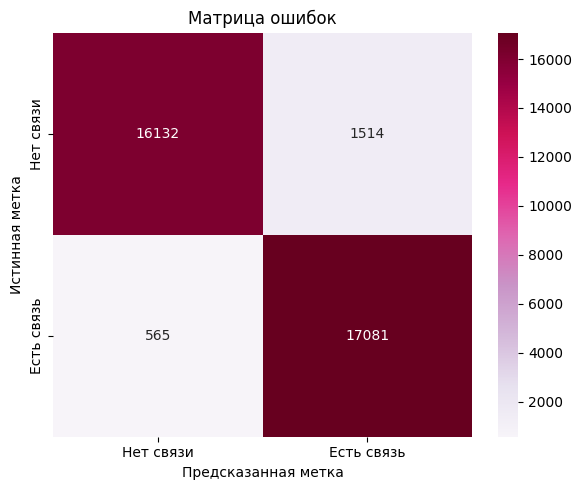

In [ ]:
test_out = model(test_data.x, test_data.edge_index, edge_pairs=test_data.edge_label_index)
test_scores = test_out.detach().cpu().numpy()
test_preds = (test_scores > 0.5).astype(int)
test_labels_np = test_data.edge_label.cpu().numpy()

cm = confusion_matrix(test_labels_np, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd",
            xticklabels=["Нет связи", "Есть связь"],
            yticklabels=["Нет связи", "Есть связь"])
plt.title("Матрица ошибок")
plt.xlabel("Предсказанная метка")
plt.ylabel("Истинная метка")
plt.tight_layout()
plt.show()

- ROC-AUC достигает значений 0.94 на тесте, что говорит о хорошей способности модели различать пары с и без связи.
- F1-score для обоих классов сбалансирован (0.94), что подтверждается отчётом классификации.
- Матрица ошибок показывает, что модель способна предсказывать как наличие, так и отсутствие связи, ошибок не очень много


### Проверка на "сложных данных"

При попытке предсказать связи с помощью классических методов, таких как коэффициент Жаккара и индекс Адамика-Адара, была выявлена ограниченность этих подходов — они не способны находить связи между узлами, не имеющими общих соседей. Это делает их неэффективными для "сложных данных", где связь не основана на прямом пересечении окружения.

Чтобы попробовать решить эту проблему, была применена модель на основе графовых нейронных сетей, способная учитывать более сложную структуру графа и признаки узлов. Предполагается, что такие модели могут выявлять скрытые закономерности и предсказывать наличие связи, даже если у узлов нет общих соседей.

In [ ]:
G_train = nx.Graph()
G_train.add_edges_from(train_data.edge_index.t().tolist())

In [ ]:
u_list, v_list = test_data.edge_label_index[0].tolist(), test_data.edge_label_index[1].tolist()
hard_mask = []

for u, v in zip(u_list, v_list):
    if u in G_train and v in G_train:
        common_neighbors = set(G_train.neighbors(u)) & set(G_train.neighbors(v))
        if len(common_neighbors) == 0:
            hard_mask.append(True)
        else:
            hard_mask.append(False)
    else:
        hard_mask.append(False)

In [ ]:
hard_mask = torch.tensor(hard_mask, dtype=torch.bool)

hard_edge_index = test_data.edge_label_index[:, hard_mask]
hard_edge_label = test_data.edge_label[hard_mask]

with torch.no_grad():

    hard_scores = model(test_data.x, test_data.edge_index, edge_pairs=hard_edge_index)
    hard_preds = (hard_scores > 0.5).long().cpu().numpy()
    hard_labels_np = hard_edge_label.cpu().numpy()
    hard_scores_np = hard_scores.cpu().numpy()

print(classification_report(hard_labels_np, hard_preds, target_names=["Нет связи", "Есть связь"]))

print(f'ROC-AUC: {roc_auc_score(hard_labels_np, hard_scores_np):.2f}')

              precision    recall  f1-score   support

   Нет связи       1.00      0.84      0.91     15328
  Есть связь       0.04      0.94      0.07       101

    accuracy                           0.84     15429
   macro avg       0.52      0.89      0.49     15429
weighted avg       0.99      0.84      0.91     15429

ROC-AUC: 0.94


Модель показала хорошую предсказательную способность на сложных данных. Precision(это метрика оценки качества модели в задачах классификации, которая измеряет долю правильно предсказанных положительных классов относительно всех объектов, которые модель предсказала как положительные.) для положительного класса очень мал из-за сильного дисбаланса классов. В такой ситуации даже одна ошибка сильно сказывается на метриках.

## Улучшение модели (Random Walk)

Для улучшения модели воспользуемся векторным представлением узлов, которое будет генерироваться методом Node2Vec.
Node2Vec основан на случайном блуждании (random walk) с последующим применением Word2Vec. Алгоритм фиксирует структурные свойтсва графа, такие как роль узла и его сообщество, а также его отношение с другими узлами в графе.



In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=100, workers=8)
model_n2v = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

In [ ]:
model_n2v.save("node2vec.model")

In [ ]:
from gensim.models import Word2Vec

model_n2v = Word2Vec.load("node2vec.model")

К признакам узлов добавляем структурные эмбеддинги node2vec.

In [ ]:
n2v = np.vstack([model_n2v.wv[str(node)] for node in nodes])
attribute_features = full_features.values.astype(np.float32)

scaler_attr = StandardScaler()
attr_scaled = scaler_attr.fit_transform(attribute_features)

scaler_n2v = StandardScaler()
n2v_scaled = scaler_n2v.fit_transform(n2v)

combined = np.concatenate([attr_scaled, n2v_scaled], axis=1)
x = torch.tensor(combined, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
transform = RandomLinkSplit(
    is_undirected=True,
    split_labels=False,
    add_negative_train_samples=True,
    num_val=0.0,
    num_test=0.2
)
train_data, _, test_data = transform(data)

Убираем из модели нормализацию, так как признаки уже были стандартизированы перед соединением.

In [ ]:
class Model_new(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1   = nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2   = nn.BatchNorm1d(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)


        feat_dim = out_channels * 3
        self.fc1    = nn.Linear(feat_dim, hidden_channels)
        self.bn3    = nn.BatchNorm1d(hidden_channels)
        self.fc2    = nn.Linear(hidden_channels, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_pairs=None):
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        #x = F.normalize(x, p=2, dim=-1)

        if edge_pairs is not None:
            u, v = edge_pairs
            x_u, x_v = x[u], x[v]

            prod = x_u * x_v
            edge_feat = torch.cat([x_u, x_v, prod], dim=-1)

            h = F.relu(self.bn3(self.fc1(edge_feat)))
            h = self.dropout(h)
            return torch.sigmoid(self.fc2(h)).squeeze()
        return x

In [ ]:
model_2 = Model_new(in_channels=107, hidden_channels=256, out_channels=64)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.005)
criterion = nn.BCELoss()

In [ ]:
start_time = time.time()

train_losses, train_roc_aucs, train_f1s, test_roc_aucs, test_f1s = train(model_2, criterion, optimizer, train_data, test_data, epochs=100)

end_time = time.time()

Epoch 000 | Loss: 0.4344 | Train ROC-AUC: 0.6492, F1: 0.5769 | Test ROC-AUC: 0.6494, F1: 0.5784
Epoch 010 | Loss: 0.2013 | Train ROC-AUC: 0.9481, F1: 0.8335 | Test ROC-AUC: 0.9474, F1: 0.8343
Epoch 020 | Loss: 0.1720 | Train ROC-AUC: 0.9742, F1: 0.9314 | Test ROC-AUC: 0.9729, F1: 0.9311
Epoch 030 | Loss: 0.1589 | Train ROC-AUC: 0.9792, F1: 0.9430 | Test ROC-AUC: 0.9782, F1: 0.9419
Epoch 040 | Loss: 0.1486 | Train ROC-AUC: 0.9822, F1: 0.9494 | Test ROC-AUC: 0.9812, F1: 0.9481
Epoch 050 | Loss: 0.1371 | Train ROC-AUC: 0.9846, F1: 0.9514 | Test ROC-AUC: 0.9835, F1: 0.9486
Epoch 060 | Loss: 0.1268 | Train ROC-AUC: 0.9863, F1: 0.9475 | Test ROC-AUC: 0.9851, F1: 0.9440
Epoch 070 | Loss: 0.1176 | Train ROC-AUC: 0.9880, F1: 0.9479 | Test ROC-AUC: 0.9867, F1: 0.9445
Epoch 080 | Loss: 0.1102 | Train ROC-AUC: 0.9887, F1: 0.9604 | Test ROC-AUC: 0.9875, F1: 0.9557
Epoch 090 | Loss: 0.1031 | Train ROC-AUC: 0.9900, F1: 0.9576 | Test ROC-AUC: 0.9886, F1: 0.9516


In [ ]:
print(f"Время обучения: {(end_time - start_time)/60:.2f} минут")

Время обучения: 4.98 минут


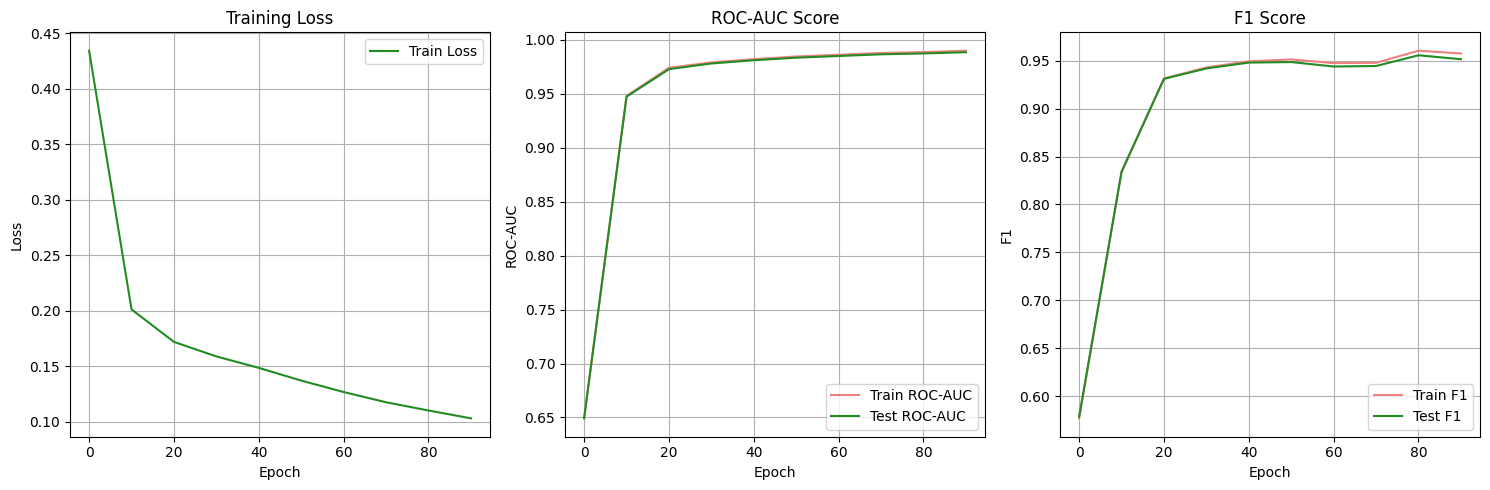

In [ ]:
graphics(train_losses, train_roc_aucs, test_roc_aucs, train_f1s, test_f1s)

Отчет о классификации:

In [ ]:
test_out = model_2(test_data.x, test_data.edge_index, edge_pairs=test_data.edge_label_index)
test_scores = test_out.detach().cpu().numpy()
test_preds = (test_scores > 0.5).astype(int)
test_labels_np = test_data.edge_label.cpu().numpy()

report = classification_report(test_labels_np, test_preds, target_names=["Нет связи", "Есть связь"])
print(report)

              precision    recall  f1-score   support

   Нет связи       0.98      0.95      0.96     17646
  Есть связь       0.95      0.98      0.96     17646

    accuracy                           0.96     35292
   macro avg       0.96      0.96      0.96     35292
weighted avg       0.96      0.96      0.96     35292



Матрица ошибок

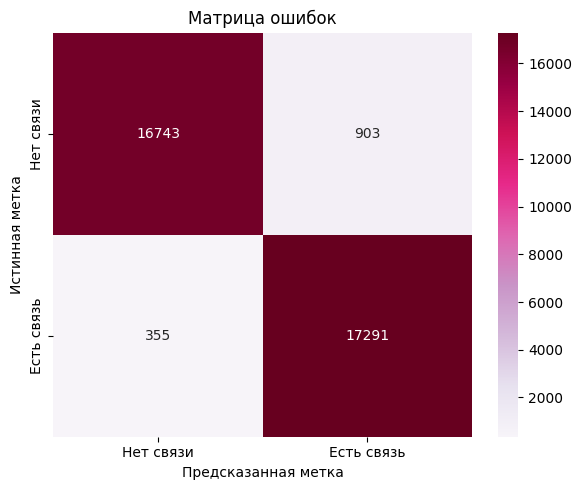

In [ ]:
test_out = model_2(test_data.x, test_data.edge_index, edge_pairs=test_data.edge_label_index)
test_scores = test_out.detach().cpu().numpy()
test_preds = (test_scores > 0.5).astype(int)
test_labels_np = test_data.edge_label.cpu().numpy()

cm = confusion_matrix(test_labels_np, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd",
            xticklabels=["Нет связи", "Есть связь"],
            yticklabels=["Нет связи", "Есть связь"])
plt.title("Матрица ошибок")
plt.xlabel("Предсказанная метка")
plt.ylabel("Истинная метка")
plt.tight_layout()
plt.show()

- Добавление структурных признаков улучшило метрику ROC-AUC(0.94 -> 0.98)
- По confusion_matrix видно, что модель стала реже ошибаться
- В отчете о классификации F1 сбалансирован (0.97 для обоих классов)

Вывод:
Объединение исходных признаков с эмбеддингами, полученными с помощью node2vec, улучшило предсказательную способность модели.

### Проверка на "сложных данных"

In [ ]:
G_train = nx.Graph()
G_train.add_edges_from(train_data.edge_index.t().tolist())

In [ ]:
u_list, v_list = test_data.edge_label_index[0].tolist(), test_data.edge_label_index[1].tolist()
hard_mask = []

for u, v in zip(u_list, v_list):
    if u in G_train and v in G_train:
        common_neighbors = set(G_train.neighbors(u)) & set(G_train.neighbors(v))
        if len(common_neighbors) == 0:
            hard_mask.append(True)
        else:
            hard_mask.append(False)
    else:
        hard_mask.append(False)

In [ ]:
hard_mask = torch.tensor(hard_mask, dtype=torch.bool)

hard_edge_index = test_data.edge_label_index[:, hard_mask]
hard_edge_label = test_data.edge_label[hard_mask]

with torch.no_grad():

    hard_scores = model_2(test_data.x, test_data.edge_index, edge_pairs=hard_edge_index)
    hard_preds = (hard_scores > 0.5).long().cpu().numpy()
    hard_labels_np = hard_edge_label.cpu().numpy()
    hard_scores_np = hard_scores.cpu().numpy()

print(classification_report(hard_labels_np, hard_preds, target_names=["Нет связи", "Есть связь"]))

print(f'ROC-AUC: {roc_auc_score(hard_labels_np, hard_scores_np):.2f}')

              precision    recall  f1-score   support

   Нет связи       1.00      0.64      0.78     15241
  Есть связь       0.02      0.99      0.04       105

    accuracy                           0.64     15346
   macro avg       0.51      0.82      0.41     15346
weighted avg       0.99      0.64      0.78     15346

ROC-AUC: 0.97


ROC-AUC стал выше, но из-за осбенности данных (сильный дисбаланс), мы видим низкие precision и f1 для положительного класса.

Вывод:

В ходе работы были сопоставлены два подхода для прогнозирования связей в Facebook - графе. Классические методы показали себя хорошо (ROC-AUC = 0.99), но на разреженных участках графа они полностью теряют свою силу.

Модель глубокого обучения уступает классическим методам (ROC-AUC = 0.97), однако сохранила работоспособность в «сложных» зонах.

Было выявлено, что на разреженных участках графов современные методы справляются намного лучше классических, выявляют скрытые закономерности, когда общие соседи отсутсвуют.
В силу особенностей датасета (малое количество "сложных данных" и сильный дисбаланс классов), сложно получить хорошие метрики, даже одна ошибка очень сильно сказывается на результатах.